In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shap

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
seed=42

c:\Users\zive9\anaconda3\envs\iod\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import the dataset
df = pd.read_csv("Datasets\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv\WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

### Preprocess the data

In [3]:
# Identify the features which can be targeted in advertising 
targetable = ["State", "Education", "EmploymentStatus", "Gender", "Income", "Location Code",
              "Marital Status"]

In [4]:
# Set Customer as index
df.set_index("Customer", inplace=True)

# Create a new df with the features we want to use in modelling:
# Targetable features, and Customer Lifetime Value. 
df_target = df[targetable + ["Customer Lifetime Value"]]

In [5]:
df_target.head()

,State,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Customer Lifetime Value
Customer,,,,,,,,
BU79786,Washington,Bachelor,Employed,F,56274,Suburban,Married,2763.519279
QZ44356,Arizona,Bachelor,Unemployed,F,0,Suburban,Single,6979.535903
AI49188,Nevada,Bachelor,Employed,F,48767,Suburban,Married,12887.431650
WW63253,California,Bachelor,Unemployed,M,0,Suburban,Married,7645.861827
HB64268,Washington,Bachelor,Employed,M,43836,Rural,Single,2813.692575


In [6]:
# Turn Customer Lifetime Value into a categorical feature by creating a new column in which if Customer Lifetime Value
# is greater than 10,000 the value is 1, else 0
df_target["CLV"] = np.where(df_target["Customer Lifetime Value"] > 10000, 1, 0)


C:\Users\zive9\AppData\Local\Temp\ipykernel_22224\1195316722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target["CLV"] = np.where(df_target["Customer Lifetime Value"] > 10000, 1, 0)


In [7]:
df_target["Income"].describe()

count     9134.000000
mean     37657.380009
std      30379.904734
min          0.000000
25%          0.000000
50%      33889.500000
75%      62320.000000
max      99981.000000
Name: Income, dtype: float64

In [8]:
# Categorise Income into 4 categories: 0, 1, 2, 3. If Income is 0, 
# then 0, if Income is between 1 and 30,000, then 1, if Income is 
# between 30,000 and 60,000, then 2, else 3
df_target["Income"] = np.where(df_target["Income"] == 0, 0, 
                              np.where(df_target["Income"] <= 30000, 1, 
                                       np.where(df_target["Income"] <= 60000, 2, 3)))

C:\Users\zive9\AppData\Local\Temp\ipykernel_22224\3602090309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target["Income"] = np.where(df_target["Income"] == 0, 0,


In [9]:
df_target.drop("Customer Lifetime Value", axis=1, inplace=True)

C:\Users\zive9\AppData\Local\Temp\ipykernel_22224\3283645787.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target.drop("Customer Lifetime Value", axis=1, inplace=True)


In [10]:
df_target.head()

,State,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,CLV
Customer,,,,,,,,
BU79786,Washington,Bachelor,Employed,F,2,Suburban,Married,0
QZ44356,Arizona,Bachelor,Unemployed,F,0,Suburban,Single,0
AI49188,Nevada,Bachelor,Employed,F,2,Suburban,Married,1
WW63253,California,Bachelor,Unemployed,M,0,Suburban,Married,0
HB64268,Washington,Bachelor,Employed,M,2,Rural,Single,0


### Logistic Regression Pipeline

In [11]:
# Define the feature types
categorical_features = ["State", "Education", "EmploymentStatus", "Gender", "Location Code", "Marital Status", "Income"]
# numeric_features = ["Income"]

# Create the preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))
])

# Create the preprocessing for numeric features
# numeric_transformer = Pipeline(steps=[
#     ("scaler", MinMaxScaler())
# ])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)
        # ("num", numeric_transformer, numeric_features)
    ]
)

# Define the model
lr = LogisticRegression()

# Create the pipeline
lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", lr)
])

In [12]:
# Define target and features
X = df_target.drop("CLV", axis=1)
y = df_target["CLV"]

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [14]:
# Fit the model
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['State', 'Education',
                                                   'EmploymentStatus', 'Gender',
                                                   'Location Code',
                                                   'Marital Status',
                                                   'Income'])])),
                ('model', LogisticRegression())])

In [15]:
# Predict the target
y_pred = lr_pipeline.predict(X_test)


In [16]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7974822112753147


In [17]:
# Cross validate the model
scores = cross_val_score(lr_pipeline, X, y, cv=10)
print(f"Cross val scores: {scores}")
print(f"Mean: {scores.mean()}")
print(f"Std: {scores.std()}")
print(f"Min: {scores.min()}")
print(f"Max: {scores.max()}")
print(f"Range: {scores.max() - scores.min()}")
print(f"Median: {np.median(scores)}")


Cross val scores: [0.79321663 0.79321663 0.79321663 0.79321663 0.79408543 0.79408543
 0.79408543 0.79408543 0.79299014 0.79299014]
Mean: 0.793518853612181
Std: 0.0004699440675305528
Min: 0.7929901423877328
Max: 0.7940854326396495
Range: 0.0010952902519166807
Median: 0.7932166301969366


In [18]:
# Extract the coefficients from the model to determine feature importance
model = lr_pipeline.named_steps["model"]
coefs = model.coef_
intercept = model.intercept_

# Extract all the feature names from the preprocessor
feature_names = lr_pipeline.named_steps["preprocessor"].get_feature_names_out()

# Combine the feature names with the coefficients
lr_feature_importance = pd.DataFrame(coefs, columns=feature_names).sort_values(by=0, axis=1, ascending=False)

# Add the intercept
# lr_feature_importance["intercept"] = intercept

# Print the feature importance
print(lr_feature_importance.T)


                                            0
cat__EmploymentStatus_Retired        0.188630
cat__Education_Master                0.160646
cat__Location Code_Suburban          0.081176
cat__Marital Status_Divorced         0.074489
cat__Income_2                        0.065245
cat__State_California                0.048531
cat__Education_High School or Below  0.044806
cat__State_Oregon                    0.036410
cat__Income_3                        0.023397
cat__Income_1                        0.010760
cat__State_Washington                0.005418
cat__Marital Status_Single          -0.004525
cat__Education_College              -0.007682
cat__Location Code_Urban            -0.009634
cat__State_Nevada                   -0.019699
cat__EmploymentStatus_Medical Leave -0.021614
cat__EmploymentStatus_Disabled      -0.033161
cat__EmploymentStatus_Employed      -0.034453
cat__Gender_M                       -0.035465
cat__Marital Status_Married         -0.069736
cat__State_Arizona                

**Using Logistic Regression, the targeting to get customers with the highest CLV is:**

- Employment Status:  Retired

- Education: Masters

- Marital Status: Divorced

- Income: 30,000+

- Gender: Female 

- Location: California / Oregon / Washington

### Random Forest Pipeline

In [19]:
# Define the feature types
categorical_features = ["State", "Education", "EmploymentStatus", "Gender", "Location Code", "Marital Status", "Income"]
# numeric_features = ["Income"]

# Create the preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)
        # ("num", numeric_transformer, numeric_features)
    ]
)

# Define the model
rfc = RandomForestClassifier()

# Create the pipeline
rfc_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rfc)
])

In [20]:
# Define target and features
X = df_target.drop("CLV", axis=1)
y = df_target["CLV"]

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [22]:
# Fit the model
rfc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['State', 'Education',
                                                   'EmploymentStatus', 'Gender',
                                                   'Location Code',
                                                   'Marital Status',
                                                   'Income'])])),
                ('model', RandomForestClassifier())])

In [23]:
# Predict the target
y_pred = rfc_pipeline.predict(X_test)

In [24]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7755883962780514


In [25]:
# Cross validate the model
scores = cross_val_score(rfc_pipeline, X, y, cv=10)
print(f"Cross val scores: {scores}")
print(f"Mean: {scores.mean()}")
print(f"Std: {scores.std()}")
print(f"Min: {scores.min()}")
print(f"Max: {scores.max()}")
print(f"Range: {scores.max() - scores.min()}")
print(f"Median: {np.median(scores)}")

Cross val scores: [0.76148796 0.76805252 0.77680525 0.7702407  0.76670318 0.77108434
 0.7645126  0.76779847 0.76779847 0.77875137]
Mean: 0.7693234845089528
Std: 0.004964639815135727
Min: 0.7614879649890591
Max: 0.778751369112815
Range: 0.01726340412375582
Median: 0.7679254915025129


In [26]:
rfc_pipe_feature_importance = pd.Series(rfc_pipeline.named_steps["model"].feature_importances_, 
                               index=rfc_pipeline.named_steps["preprocessor"].get_feature_names_out()).sort_values(ascending=False)
rfc_pipe_feature_importance

cat__Gender_M                          0.164445
cat__Education_College                 0.047179
cat__State_California                  0.046883
cat__Education_Bachelor                0.045126
cat__Education_High School or Below    0.044394
cat__Location Code_Suburban            0.044067
cat__Marital Status_Married            0.043890
cat__State_Oregon                      0.043206
cat__Marital Status_Single             0.042134
cat__State_Nevada                      0.041024
cat__Location Code_Urban               0.040990
cat__Location Code_Rural               0.040707
cat__State_Arizona                     0.039843
cat__Education_Master                  0.035510
cat__Marital Status_Divorced           0.035222
cat__State_Washington                  0.033622
cat__Income_2                          0.033162
cat__Income_3                          0.030683
cat__Income_1                          0.025969
cat__Education_Doctor                  0.025343
cat__EmploymentStatus_Employed         0

### RandomForestClassifier without the pipeline for SHAP values

In [27]:
# Define X and y
X = df_target.drop("CLV", axis=1)
y = df_target["CLV"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# One Hot Encode the categorical features
encoder = OneHotEncoder(drop="if_binary", handle_unknown="ignore", dtype="float")
encoder.fit(X_train)
X_train_encoded = encoder.transform(X_train).toarray()
X_test_encoded = encoder.transform(X_test).toarray()

# Create dataframes of the encoded data
feat_names = encoder.get_feature_names_out()
X_tr = pd.DataFrame(X_train_encoded, columns=feat_names)
X_te = pd.DataFrame(X_test_encoded, columns=feat_names)

# Instantiate the model
rfc = RandomForestClassifier(n_estimators=50, random_state=seed)
rfc.fit(X_tr, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [28]:
# Combine the encoded train and test data
X_encoded = encoder.transform(X).toarray()

# Cross validate the model
scores = cross_val_score(rfc, X_encoded, y, cv=10)
print(f"Cross val scores: {scores}")
print(f"Mean: {scores.mean()}")

Cross val scores: [0.75820569 0.76477024 0.77461707 0.77242888 0.76341731 0.76670318
 0.76560789 0.76232202 0.76779847 0.78203724]
Mean: 0.7677907971651874


In [29]:
# Get the SHAP values
explainer = shap.TreeExplainer(rfc, feature_names=feat_names)
# explanation = explainer(X_te, y_test)
shap_values = explainer(X_te)


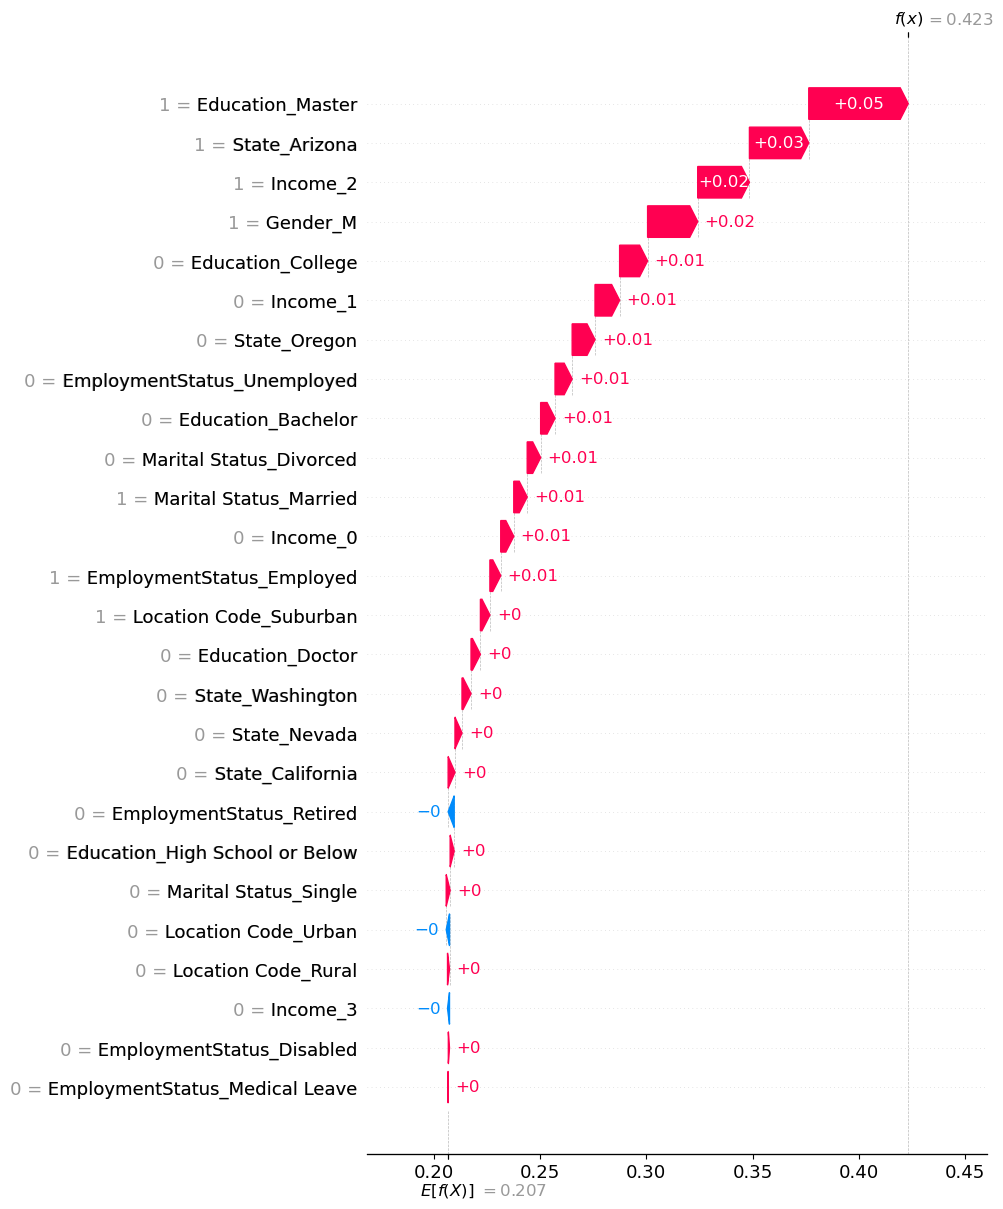

In [30]:
shap.plots.waterfall(shap_values[5,:,1], max_display=26, show=True)

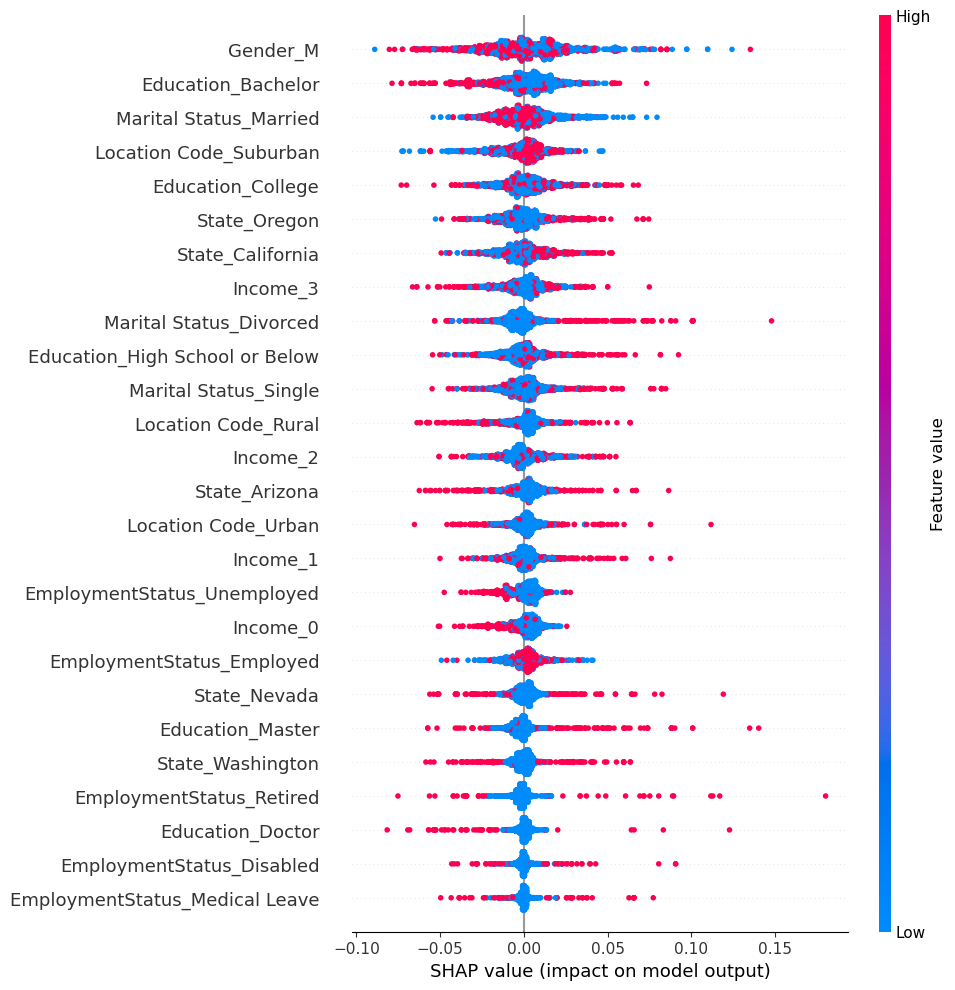

In [31]:
# Mean SHAP
shap.plots.beeswarm(shap_values[:, :, 1], max_display=27, order=shap.Explanation.abs.mean(0))

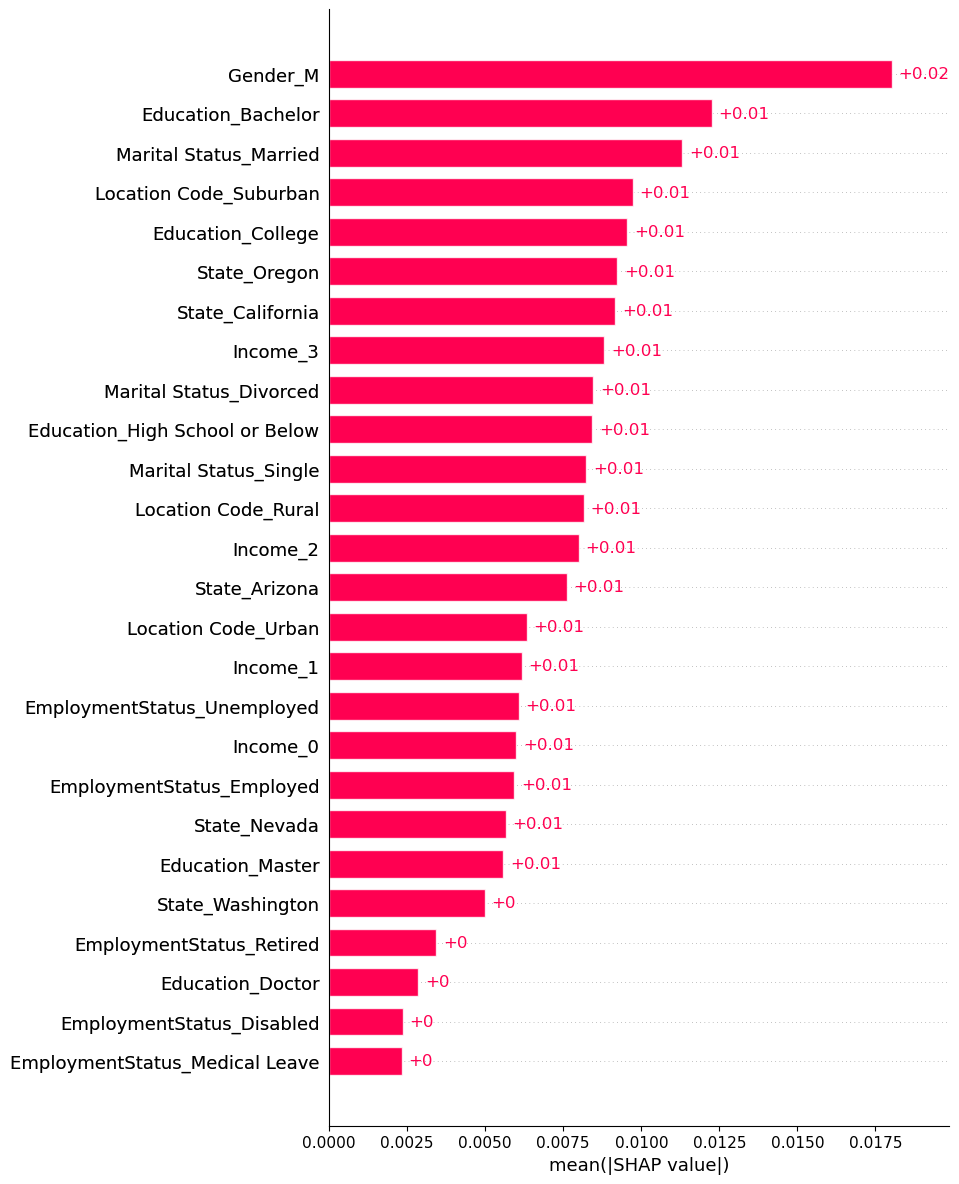

In [103]:
# SHAP bar plot of all observations 
shap.plots.bar(shap_values[:, :, 1], show=True, max_display=27)

To find the most important features (not feature values post encoding) we will get the absolute means for each encoded feature and then aggregate the SHAP feature values into SHAP features.

In [104]:
# Convert shap_values to a DataFrame if it's not already (this step may be optional)
target_shap = shap_values[:, :, 1].abs.values
shap_values_df = pd.DataFrame(target_shap, columns=X_te.columns)

# Calculate the mean of absolute SHAP values for each feature
abs_shap = []
for col in shap_values_df.columns:
    abs_shap.append(shap_values_df[col].mean())
    
abs_shap = pd.DataFrame(abs_shap, index=X_te.columns)

# Print the mean absolute SHAP values
print(abs_shap)

                                       0
State_Arizona                   0.007613
State_California                0.009162
State_Nevada                    0.005666
State_Oregon                    0.009232
State_Washington                0.004975
Education_Bachelor              0.012266
Education_College               0.009548
Education_Doctor                0.002855
Education_High School or Below  0.008429
Education_Master                0.005582
EmploymentStatus_Disabled       0.002348
EmploymentStatus_Employed       0.005932
EmploymentStatus_Medical Leave  0.002332
EmploymentStatus_Retired        0.003426
EmploymentStatus_Unemployed     0.006083
Gender_M                        0.018018
Income_0                        0.005994
Income_1                        0.006175
Income_2                        0.008007
Income_3                        0.008808
Location Code_Rural             0.008167
Location Code_Suburban          0.009722
Location Code_Urban             0.006327
Marital Status_D

In [105]:
# Group the mean absolute SHAP values by the feature names
mean_abs_shap = abs_shap.groupby(abs_shap.index.str.split("_").str[0]).mean()

mean_abs_shap.sort_values(by=0, ascending=False, inplace=True)

mean_abs_shap

,0
Gender,0.018018
Marital Status,0.009341
Location Code,0.008072
Education,0.007736
State,0.007330
Income,0.007246
EmploymentStatus,0.004024


In [109]:
# Add a new column to abs_shap which is the feature name before the _
abs_shap["Feature"] = abs_shap.index.str.split("_").str[0]

# Select the highest absolute SHAP value for each Feature and retain the index
abs_shap["Values"] = abs_shap.index

feats = abs_shap["Feature"].unique()

top_feat_values = []
for feat in feats:
    top_feat_values.append(abs_shap[abs_shap["Feature"] == feat].sort_values(by=0, ascending=False).iloc[0])
    
top_feat_values = pd.DataFrame(top_feat_values)

top_feat_values

,0,Feature,Values
State_Oregon,0.009232,State,State_Oregon
Education_Bachelor,0.012266,Education,Education_Bachelor
EmploymentStatus_Unemployed,0.006083,EmploymentStatus,EmploymentStatus_Unemployed
Gender_M,0.018018,Gender,Gender_M
Income_3,0.008808,Income,Income_3
Location Code_Suburban,0.009722,Location Code,Location Code_Suburban
Marital Status_Married,0.011314,Marital Status,Marital Status_Married


Using SHAP values to find feature importance from a Random Forest Classifier, these are the optimal targeting to acquire customers with the highest Customer Lifetime Value:

Gender:  F

Marital Status:  Married

Employment Status:  Employed

Income:  over 60,000

Education:  Bachelors and above

Location Code:  Suburban

State:  Oregon


In [111]:
rfc_feature_importance = pd.Series(rfc.feature_importances_, 
                               index=encoder.get_feature_names_out()).sort_values(ascending=False)
rfc_feature_importance

Gender_M                          0.173967
State_California                  0.049339
Education_College                 0.044764
Marital Status_Married            0.044699
Education_High School or Below    0.043963
State_Oregon                      0.043404
State_Arizona                     0.043114
State_Nevada                      0.042222
Marital Status_Single             0.041469
Location Code_Suburban            0.040788
Marital Status_Divorced           0.039697
Education_Bachelor                0.037367
State_Washington                  0.036352
Education_Master                  0.035523
Location Code_Rural               0.035289
Location Code_Urban               0.035139
Income_2                          0.034558
Income_3                          0.032068
Income_1                          0.026801
Education_Doctor                  0.026735
EmploymentStatus_Employed         0.024700
EmploymentStatus_Retired          0.020143
EmploymentStatus_Medical Leave    0.018661
EmploymentS

### XGBoost Classifier

In [113]:
# Define X and y
X = df_target.drop("CLV", axis=1)
y = df_target["CLV"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# One Hot Encode the categorical features
encoder = OneHotEncoder(drop="if_binary", handle_unknown="ignore", dtype="float")
encoder.fit(X_train)
X_train_encoded = encoder.transform(X_train).toarray()
X_test_encoded = encoder.transform(X_test).toarray()

# Create dataframes of the encoded data
feat_names = encoder.get_feature_names_out()
X_tr = pd.DataFrame(X_train_encoded, columns=feat_names)
X_te = pd.DataFrame(X_test_encoded, columns=feat_names)

# Instantiate the model
xgbc = XGBClassifier(n_estimators=50, random_state=seed)
xgbc.fit(X_tr, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [114]:
# Evaluate the model
y_pred = xgbc.predict(X_te)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7920087575259989


In [115]:
# Combine the encoded train and test data
X_encoded = encoder.transform(X).toarray()

# Cross validate the model
scores = cross_val_score(xgbc, X_encoded, y, cv=10)
print(f"Cross val scores: {scores}")
print(f"Mean: {scores.mean()}")

Cross val scores: [0.78227571 0.78555799 0.79212254 0.78446389 0.78094195 0.78751369
 0.79189485 0.77437021 0.7864184  0.78751369]
Mean: 0.785307292428117


In [118]:
# Get the SHAP values
explainer = shap.TreeExplainer(xgbc, feature_names=feat_names)
# explanation = explainer(X_te, y_test)
shap_values = explainer(X_te)

In [121]:
shap_values.shape

(1827, 26)

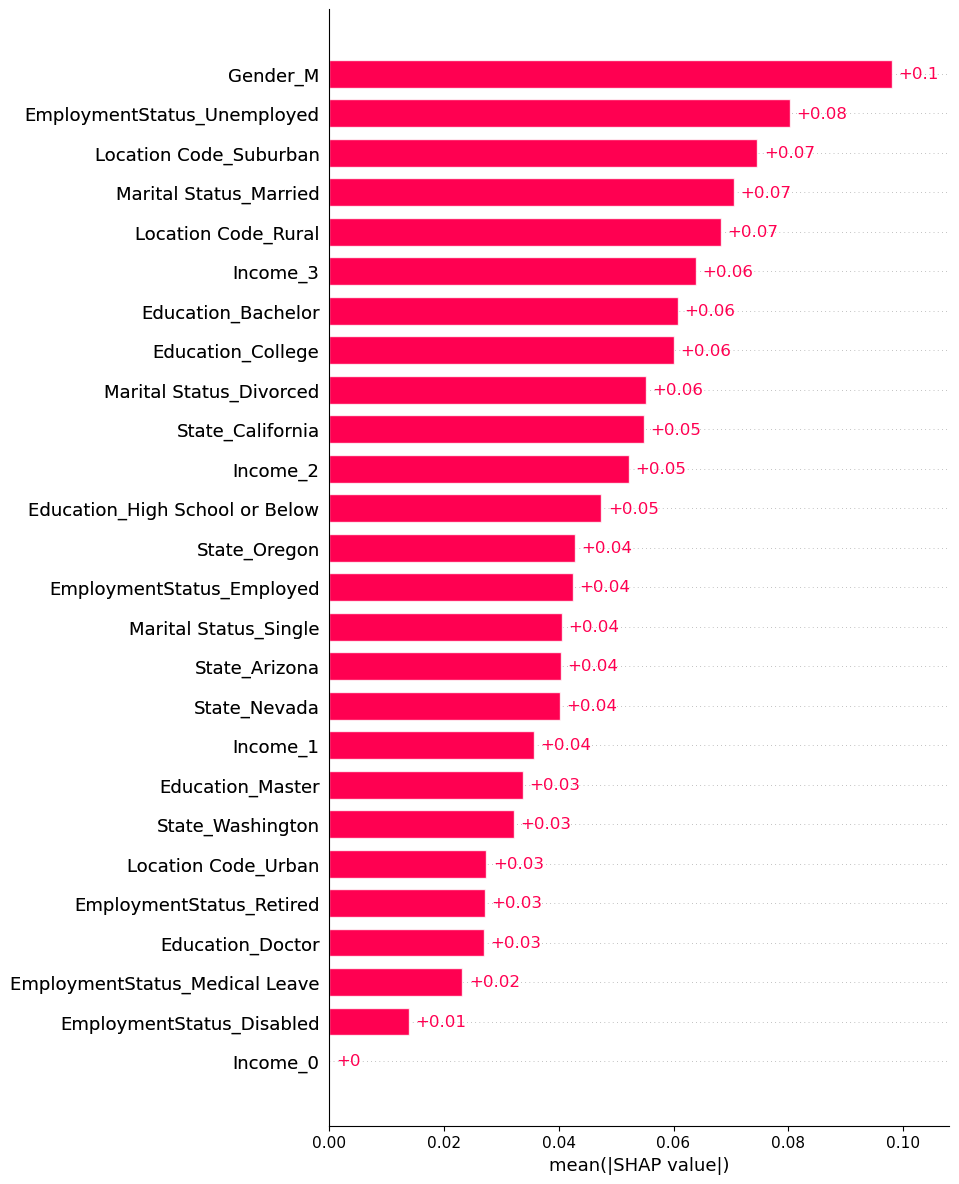

In [122]:
# SHAP bar plot of all observations 
shap.plots.bar(shap_values, show=True, max_display=27)

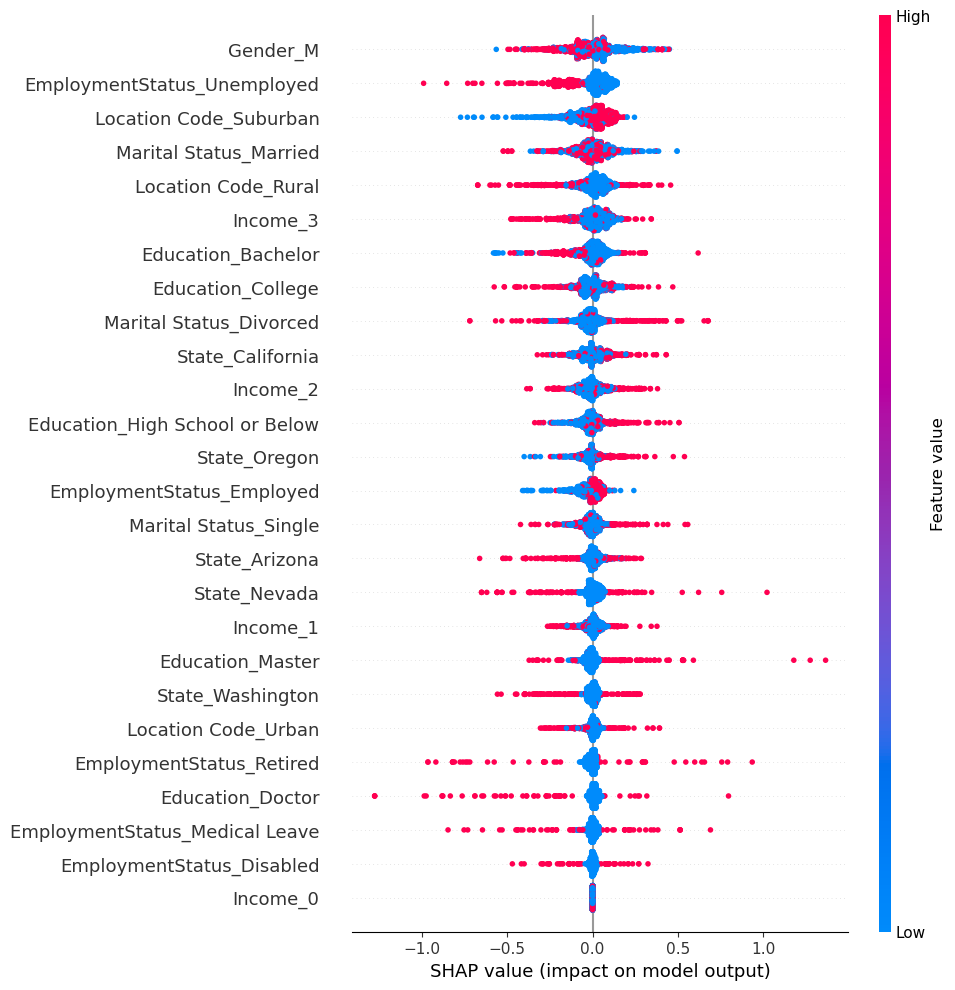

In [123]:
# Mean SHAP
shap.plots.beeswarm(shap_values, max_display=27, order=shap.Explanation.abs.mean(0))

In [125]:
# Convert shap_values to a DataFrame if it's not already 
target_shap = shap_values.abs.values
shap_values_df = pd.DataFrame(target_shap, columns=X_te.columns)

# Calculate the mean of absolute SHAP values for each feature
abs_shap = []
for col in shap_values_df.columns:
    abs_shap.append(shap_values_df[col].mean())
    
abs_shap = pd.DataFrame(abs_shap, index=X_te.columns)

# Print the mean absolute SHAP values
print(abs_shap)

                                       0
State_Arizona                   0.040359
State_California                0.054853
State_Nevada                    0.040169
State_Oregon                    0.042849
State_Washington                0.032192
Education_Bachelor              0.060790
Education_College               0.060063
Education_Doctor                0.026989
Education_High School or Below  0.047414
Education_Master                0.033740
EmploymentStatus_Disabled       0.013845
EmploymentStatus_Employed       0.042489
EmploymentStatus_Medical Leave  0.023182
EmploymentStatus_Retired        0.027143
EmploymentStatus_Unemployed     0.080291
Gender_M                        0.097991
Income_0                        0.000000
Income_1                        0.035690
Income_2                        0.052171
Income_3                        0.063908
Location Code_Rural             0.068235
Location Code_Suburban          0.074620
Location Code_Urban             0.027347
Marital Status_D

In [126]:
# Group the mean absolute SHAP values by the feature names
mean_abs_shap = abs_shap.groupby(abs_shap.index.str.split("_").str[0]).mean()

mean_abs_shap.sort_values(by=0, ascending=False, inplace=True)

mean_abs_shap

,0
Gender,0.097991
Location Code,0.056734
Marital Status,0.055397
Education,0.045799
State,0.042084
Income,0.037942
EmploymentStatus,0.037390


In [127]:
# Add a new column to abs_shap which is the feature name before the _
abs_shap["Feature"] = abs_shap.index.str.split("_").str[0]

# Select the highest absolute SHAP value for each Feature and retain the index
abs_shap["Values"] = abs_shap.index

feats = abs_shap["Feature"].unique()

top_feat_values = []
for feat in feats:
    top_feat_values.append(abs_shap[abs_shap["Feature"] == feat].sort_values(by=0, ascending=False).iloc[0])
    
top_feat_values = pd.DataFrame(top_feat_values)

top_feat_values

,0,Feature,Values
State_California,0.054853,State,State_California
Education_Bachelor,0.060790,Education,Education_Bachelor
EmploymentStatus_Unemployed,0.080291,EmploymentStatus,EmploymentStatus_Unemployed
Gender_M,0.097991,Gender,Gender_M
Income_3,0.063908,Income,Income_3
Location Code_Suburban,0.074620,Location Code,Location Code_Suburban
Marital Status_Married,0.070533,Marital Status,Marital Status_Married


Using SHAP values to find feature importance from a XGB Classifier, these are the optimal targeting to acquire customers with the highest Customer Lifetime Value:

Gender:  F

Marital Status:  Married

Employment Status:  Employed

Income:  over 60,000

Education:  Bachelors and above

Location Code:  Suburban

State:  California

In [128]:
# Get the feature importances from the model
xgbc_feature_importance = pd.Series(xgbc.feature_importances_, 
                               index=encoder.get_feature_names_out()).sort_values(ascending=False)
xgbc_feature_importance

EmploymentStatus_Unemployed       0.054234
Location Code_Suburban            0.051300
Marital Status_Married            0.049358
Education_College                 0.048855
Education_Master                  0.047174
Income_3                          0.045294
Marital Status_Single             0.045067
EmploymentStatus_Employed         0.043393
Marital Status_Divorced           0.043309
Location Code_Urban               0.042805
EmploymentStatus_Retired          0.042743
Income_1                          0.042380
EmploymentStatus_Medical Leave    0.040298
Education_Bachelor                0.040189
State_Arizona                     0.039750
State_Washington                  0.038327
State_Oregon                      0.038143
Gender_M                          0.037354
State_Nevada                      0.035100
EmploymentStatus_Disabled         0.033985
Education_High School or Below    0.030553
Income_2                          0.030534
Location Code_Rural               0.028285
State_Calif